In [1]:
import numpy as np
import os,sys,glob,json,pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

from enterprise.pulsar import Pulsar as ePulsar

In [2]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [3]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('nanograv')
top_dir = "/".join(splt_path[0:top_path_idx+1])

pta_sim_dir = top_dir + '/pta_sim/pta_sim/'
sys.path.insert(0,pta_sim_dir)
import noise

psrs_wn_only_dir = top_dir + '/NANOGrav/BackgroundInjections/FakePTA/'

noise_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/noisefiles_new/'
psrlist_11yr_file = top_dir + '/NANOGrav/BackgroundInjections/nano11/psrlist_Tg3yr.txt'

psrs_mdc2_dir = top_dir + '/NANOGrav/MDC2/mdc2/group1/dataset_1a/'
noise_mdc2_file =  top_dir + '/NANOGrav/MDC2/mdc2/group1/group1_psr_noise.json'

pardir = psrs_mdc2_dir
timdir = psrs_mdc2_dir

noisedir = noise_mdc2_file

pars = sorted(glob.glob(pardir+'*.par'))
tims = sorted(glob.glob(timdir+'*.tim'))
#noise_files = sorted(glob.glob(noisedir+'*.txt'))
noise_file = noise.load_noise_files(noisepath=noise_mdc2_file)

encoding = 'utf-8'
psr_list_bytes = np.loadtxt(psrlist_11yr_file,dtype='S42')
psrlist = []
for psr in psr_list_bytes:
    psrlist.append(psr.decode(encoding))

In [4]:
injection_psr_file = top_dir + '/NANOGrav/BackgroundInjections' + \
    '/SimInject5/SimRuns/simGWB_1/enterprise_pickled_psrs.pickle'

In [8]:
#Get the pickled pulsars
with open(injection_psr_file, "rb") as f:
        ePsrs = pickle.load(f)

ePsrs = []
for par,tim in zip(pars,tims):
    ePsr = ePulsar(par, tim,  ephem='DE436')
    ePsrs.append(ePsr)
    print('\rPSR {0} complete'.format(ePsr.name),end='',flush=True)

In [9]:
def make_corr(psr,noisedict):
    N = psr.toaerrs.size
    corr = np.zeros((N,N))
    _, _, U = hassen.quantize_fast(psr.toas,psr.toaerrs,dt=1)
    u = np.matmul(U,U.T)
    sigma_sqr = np.zeros(N)
    ecorrs = np.zeros(N)
    corr = np.diag(sigma_sqr) + np.diag(u*ecorrs**2)
    return corr

In [10]:
Tspan = hassen.get_Tspan(ePsrs)

In [11]:
#Get Noise Values
with open(noisedir, 'rb') as fin:
    noise_json =json.load(fin)

noiseparams = noise.handle_noise_parameters(noise_json)

In [12]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),600)

In [16]:
psrs = []

for ePsr in ePsrs:
    corr = make_corr(ePsr,noiseparams)
    #plaw = hassen.red_noise_powerlaw(A=9e-16, gamma=13/3., freqs=freqs)
    """
    if ePsr.name in rn_psrs.keys():
        Amp, gam = rn_psrs[ePsr.name]
        plaw += hassen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
    """
    corr += hassen.corr_from_psd(freqs=freqs, psd=plaw,
                               toas=ePsr.toas)
    psr = hassen.Pulsar(toas=ePsr.toas,
                      toaerrs=ePsr.toaerrs,
                      phi=ePsr.phi,theta=ePsr.theta,
                      N=corr, designmatrix=ePsr.Mmat)
    psr.name = ePsr.name
    psrs.append(psr)
    del ePsr
    print('\rPSR {0} complete'.format(psr.name),end='',flush=True)

PSR J2317+1439 complete

In [17]:
specs = []
for p in psrs:
    sp = hassen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs.append(sp)
    print('\rPSR {0} complete'.format(p.name),end='',flush=True)

PSR J2317+1439 complete

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


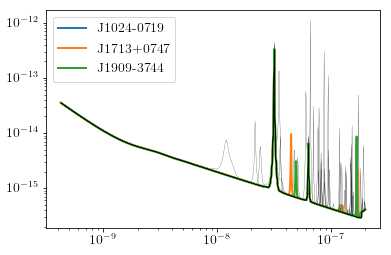

In [18]:
names = ['J1713+0747','B1937+21','J1909-3744','J1024-0719']
for sp,p in zip(specs,psrs):
    if p.name in names:
        plt.loglog(sp.freqs,sp.h_c,lw=2,label=p.name)
    else:
        plt.loglog(sp.freqs,sp.h_c, color='k',lw=0.2)

plt.legend()
plt.show()
plt.close()